<a href="https://colab.research.google.com/github/AmedeeRoy/BirdGAN/blob/master/code/2_gan_vs_hmm_200_steps_SD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN

In [1]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
%cd drive/My\ Drive/THESIS/BirdGAN

/content/drive/My Drive/THESIS/BirdGAN


## load data

In [3]:
from utils.tools import *

In [4]:
# import python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import progressbar
import time

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
import torchvision as tv

In [5]:
data = pd.read_table('./data/trips_SD_200_steps.csv', sep = ',')
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')

# colony = (-77.264, -11.773)
colony =  (-32.392, -3.819)
scale = 2e5

data = format_data(data, colony, scale)
data = data[data.dist_colony > 1000]

padding = 200
traj = padding_data(data, padding)

print('range : \nmin : ' + str(np.min(traj)) + '\nmax : ' + str(np.max(traj)))

range : 
min : -0.4786161309878112
max : 0.49283894309190646


In [6]:
class TrajDataSet(Dataset):
    def __init__(self,  traj, transform=None):
        self.traj = traj
        self.transform = transform

    def __len__(self):
        return self.traj.shape[0]

    def __getitem__(self, idx):
        # select coordinates
        sample = self.traj[idx,:,:]
        if self.transform:
            sample = self.transform(sample)

        return sample

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        return torch.FloatTensor(sample)

In [7]:
# hyperparameters
batch_size = 25
resolution = 60

## reduce size dataset
train_set = TrajDataSet(traj, transform= ToTensor())
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=False)

In [8]:
x =  next(iter(train_loader))

In [9]:
len(train_set)

50

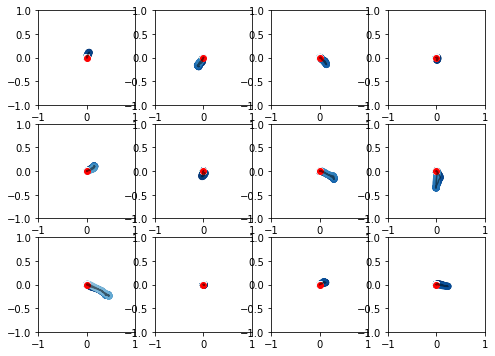

In [10]:
plt.figure(figsize = (8,8))
i = 4

for i in range(12):
    plt.subplot(4,4,i+1)
    plt.plot(x.numpy()[i,0,:], x.numpy()[i,1,:], c = 'black', alpha = 0.5)
    plt.scatter(x.numpy()[i,0,:], x.numpy()[i,1,:], c=np.arange(padding), cmap='Blues_r')
    plt.scatter(0,0, c = 'red')
    plt.xlim(-1,1)
    plt.ylim(-1,1)


## deep networks

Architecture guidelines for stable Deep Convolutional GANs (Radford et al. 2016)

- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided
convolutions (generator).
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers except for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers.



In [11]:
import torch
from torch import nn
from torch import optim
import torchvision as tv
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
def weights_init(m):
    """
    This function initializes the model weights randomly from a 
    Normal distribution. This follows the specification from the DCGAN paper.
    https://arxiv.org/pdf/1511.06434.pdf
    Source: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [14]:
def periodogram(tt):
  periodogram = torch.mean(torch.fft.fft(tt, 200).abs(), 0)
  return torch.log(periodogram)

# 1 : basic DCGAN

In [15]:
class CNNGenerator1(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(    
            nn.ConvTranspose1d(256, 128, kernel_size = 25, stride = 2, padding = 0, bias = False),
            nn.BatchNorm1d(128),
            nn.ReLU(True),

            nn.ConvTranspose1d(128, 32, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(32),
            nn.ReLU(True),

            nn.ConvTranspose1d(32, 8, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(8),
            nn.ReLU(True),

            nn.ConvTranspose1d(8, 2, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.Tanh()
         )

    def forward(self, z):    
        out = self.cnn(z)

        return out

In [16]:
z = torch.rand((batch_size, 256, 1), device = device)
gen = CNNGenerator1().to(device)
gen(z).shape

torch.Size([25, 2, 200])

In [17]:
class CNNDiscriminator1(nn.Module):
    def __init__(self):
        super().__init__()
                
        self.cnn = nn.Sequential(
            nn.Conv1d(2, 8, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(8),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(8, 32, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(32, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(128, 1, kernel_size=25, stride=2, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.cnn(x)
        return out.squeeze(1)

In [18]:
dis = CNNDiscriminator1().to(device)
dis(x.to(device)).shape

torch.Size([25, 1])

In [19]:
generator = CNNGenerator1().to(device)
discriminator = CNNDiscriminator1().to(device)

### WEIGHT INITIALIZATION
generator.apply(weights_init)
discriminator.apply(weights_init)

criterion = nn.BCELoss()

lr = 0.0002
optim_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optim_g = optim.Adam(generator.parameters(),lr= lr, betas=(0.5, 0.999))

  9% (496 of 5000) |##                   | Elapsed Time: 0:00:15 ETA:   0:02:19


Epoch [501/5000] -----------------------------------------------------------------------------
G: 0.28, Dr : 0.0, Df : 0.01


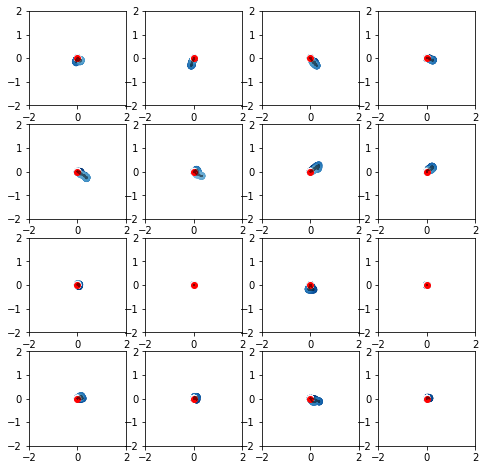

 19% (996 of 5000) |####                 | Elapsed Time: 0:00:32 ETA:   0:01:58


Epoch [1001/5000] -----------------------------------------------------------------------------
G: 0.31, Dr : 0.0, Df : 0.0


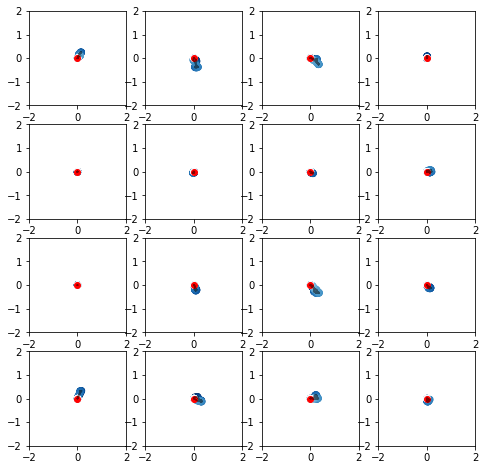

 29% (1498 of 5000) |#####               | Elapsed Time: 0:00:49 ETA:   0:01:46


Epoch [1501/5000] -----------------------------------------------------------------------------
G: 0.29, Dr : 0.0, Df : 0.0


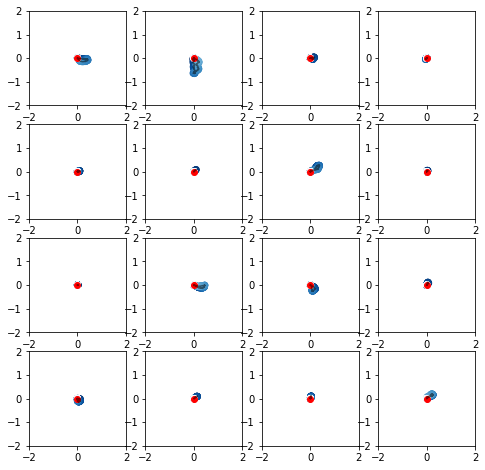

 39% (1997 of 5000) |#######             | Elapsed Time: 0:01:07 ETA:   0:01:33


Epoch [2001/5000] -----------------------------------------------------------------------------
G: 0.41, Dr : 0.0, Df : 0.0


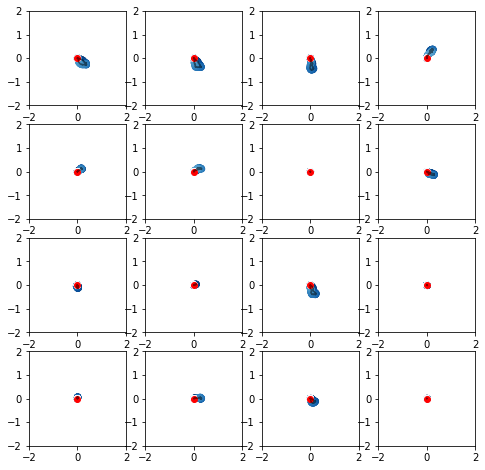

 49% (2496 of 5000) |#########           | Elapsed Time: 0:01:24 ETA:   0:01:18


Epoch [2501/5000] -----------------------------------------------------------------------------
G: 0.44, Dr : 0.0, Df : 0.01


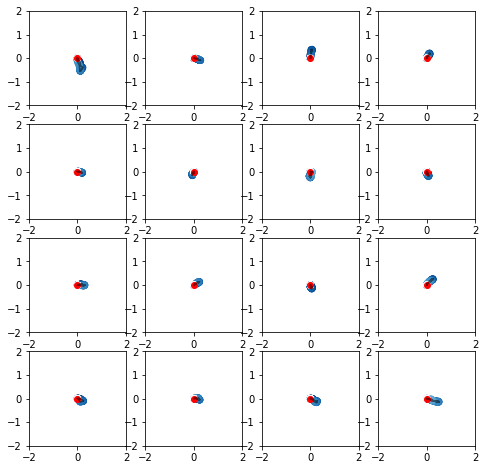

 59% (2998 of 5000) |###########         | Elapsed Time: 0:01:42 ETA:   0:01:02


Epoch [3001/5000] -----------------------------------------------------------------------------
G: 0.53, Dr : 0.0, Df : 0.0


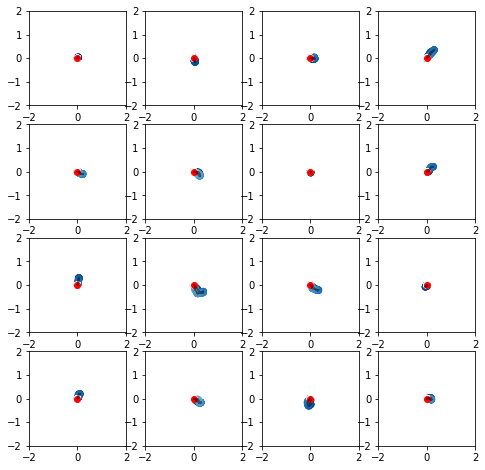

 69% (3498 of 5000) |#############       | Elapsed Time: 0:02:00 ETA:   0:00:45


Epoch [3501/5000] -----------------------------------------------------------------------------
G: 0.58, Dr : 0.0, Df : 0.0


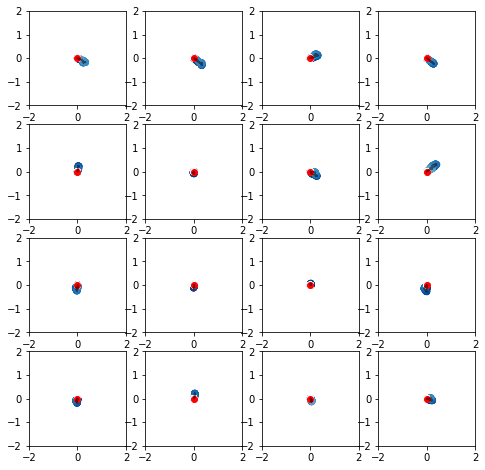

 79% (3999 of 5000) |###############     | Elapsed Time: 0:02:17 ETA:   0:00:30


Epoch [4001/5000] -----------------------------------------------------------------------------
G: 0.5, Dr : 0.0, Df : 0.0


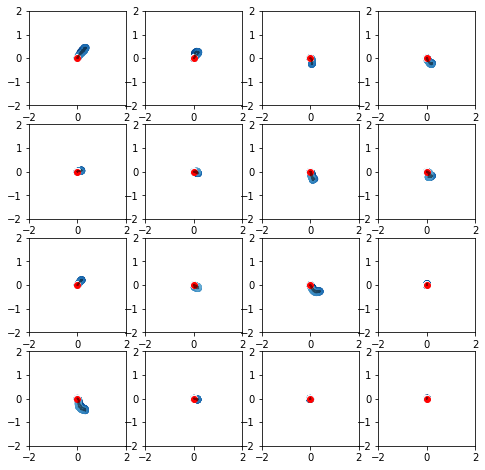

 89% (4498 of 5000) |#################   | Elapsed Time: 0:02:35 ETA:   0:00:15


Epoch [4501/5000] -----------------------------------------------------------------------------
G: 0.35, Dr : 0.01, Df : 0.01


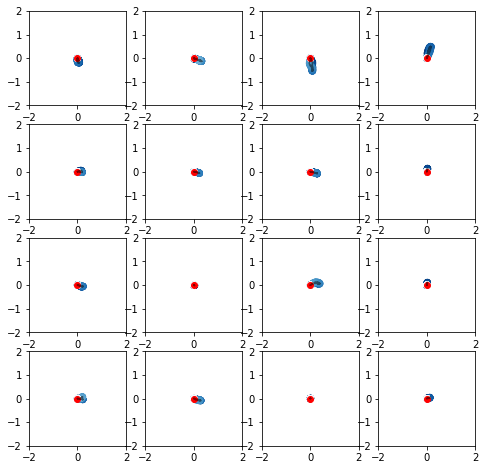

 99% (4997 of 5000) |################### | Elapsed Time: 0:02:53 ETA:   0:00:00


Epoch [5001/5000] -----------------------------------------------------------------------------
G: 0.51, Dr : 0.0, Df : 0.0


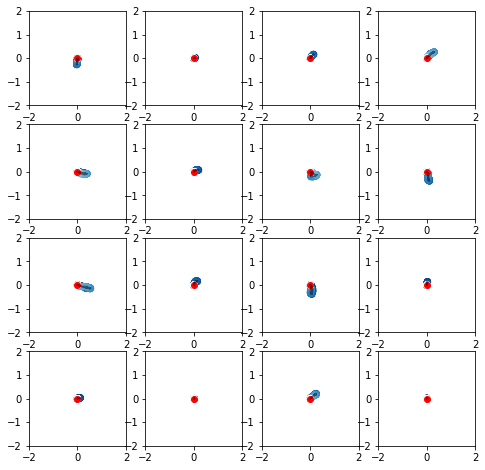

100% (5000 of 5000) |####################| Elapsed Time: 0:02:55 Time:  0:02:55


In [20]:
# Train the model
nb_epoch = 5000
score = []

time_start = time.perf_counter()
epoch = 0
for i in progressbar.progressbar(range(nb_epoch)):
    epoch +=1
    loss_g_running, loss_d_real_running, loss_d_fake_running = 0, 0, 0
    for batch, x in enumerate(train_loader):
        
        #### TRAIN DISCRIMINATOR
        ## true samples
        x = x.to(device)
        batch_size = x.shape[0]

        target_ones = torch.ones((batch_size, 1), device=device)
        target_zeros = torch.zeros((batch_size, 1), device=device)

        discriminator.zero_grad()
        pred_real = discriminator(x)
        loss_real = criterion(pred_real, target_ones)

        ## false samples
        z = torch.randn((batch_size, 256, 1), device=device)
        with torch.no_grad():
            fake_samples = generator(z)
        pred_fake = discriminator(fake_samples)
        loss_fake = criterion(pred_fake, target_zeros)
        
        # combine
        loss = (loss_real + loss_fake) / 2
        loss.backward()
        optim_d.step()

        loss_d_real_running += loss_real.item()
        loss_d_fake_running += loss_fake.item()

        #### TRAIN GENERATOR
        generator.zero_grad()
        z = torch.randn((batch_size, 256, 1), device=device)

        generated = generator(z)
        classifications = discriminator(generated)
        loss = criterion(classifications, target_ones) #+  10*torch.mean((periodogram(generated) - periodogram(x))**2)
        loss.backward()
        optim_g.step()

        loss_g_running += loss.item()   

        score.append(torch.mean((periodogram(generated) - periodogram(x))**2))

    if epoch%500 == 0:
        print('\nEpoch [{}/{}] -----------------------------------------------------------------------------'
            .format(epoch+1, nb_epoch, i, len(train_loader)))
        print('G: {}, Dr : {}, Df : {}'
            .format(np.round(loss_g_running/batch_size, 2), np.round(loss_d_real_running/batch_size, 2), np.round(loss_d_fake_running/batch_size, 2)))
        
        nb = 16
        z = torch.randn((nb, 256, 1), device=device)
        with torch.no_grad():
          generated = generator(z)
        
        traj_sim = generated.cpu().detach().numpy()

        plt.figure(figsize = (8,8))

        for i in range(16):
          plt.subplot(4,4,i+1)
          plt.plot(traj_sim[i,0,:], traj_sim[i,1,:], c = 'black', alpha = 0.5)
          plt.scatter(traj_sim[i,0,:], traj_sim[i,1,:], c=np.arange(padding), cmap='Blues_r')
          plt.scatter(0,0, c = 'red')
          plt.xlim(-2,2)
          plt.ylim(-2,2)

        plt.show()
        plt.close()

In [21]:
with open('./results/score_SD_1.npy', 'wb') as f:
    np.save(f, score)

torch.save(generator, './results/G_SD_1.pt')
torch.save(discriminator, './results/D_SD_1.pt')

# 2 : DCGAN + conv1D + Fourier regularization

In [22]:
class CNNGenerator2(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(    
            nn.ConvTranspose1d(256, 128, kernel_size = 25, stride = 2, padding = 0, bias = False),
            nn.BatchNorm1d(128),
            nn.ReLU(True),

            nn.ConvTranspose1d(128, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(64),
            nn.ReLU(True),

            nn.ConvTranspose1d(64, 32, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(32),
            nn.ReLU(True),

            nn.ConvTranspose1d(32, 16, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(16),
            nn.ReLU(True),

            nn.Conv1d(16, 8, kernel_size = 3, stride = 1, padding = 1, bias = False),
            nn.ReLU(True),
            nn.Conv1d(8, 2, kernel_size = 3, stride = 1, padding = 1, bias = False),
            nn.Tanh()

         )

    def forward(self, z):    
        out = self.cnn(z)

        return out

In [23]:
z = torch.rand((batch_size, 256, 1), device = device)
gen = CNNGenerator2().to(device)
gen(z).shape

torch.Size([25, 2, 200])

In [24]:
class CNNDiscriminator2(nn.Module):
    def __init__(self):
        super().__init__()
                
        self.cnn = nn.Sequential(
            
            nn.Conv1d(2, 8, kernel_size = 3, stride = 1, padding = 1, bias = False),
            nn.LeakyReLU(0.2, inplace=False),
            nn.Conv1d(8, 16, kernel_size = 3, stride = 1, padding = 1, bias = False),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(16, 32, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(32, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(64, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(128, 1, kernel_size=25, stride=2, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.cnn(x)
        return out.squeeze(1)

In [25]:
dis = CNNDiscriminator2().to(device)
dis(x.to(device)).shape

torch.Size([25, 1])

In [26]:
generator = CNNGenerator2().to(device)
discriminator = CNNDiscriminator2().to(device)

### WEIGHT INITIALIZATION
generator.apply(weights_init)
discriminator.apply(weights_init)

criterion = nn.BCELoss()

lr = 0.0002
optim_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optim_g = optim.Adam(generator.parameters(),lr= lr, betas=(0.5, 0.999))

  9% (498 of 5000) |##                   | Elapsed Time: 0:00:20 ETA:   0:03:00


Epoch [501/5000] -----------------------------------------------------------------------------
G: 0.36, Dr : 0.01, Df : 0.01


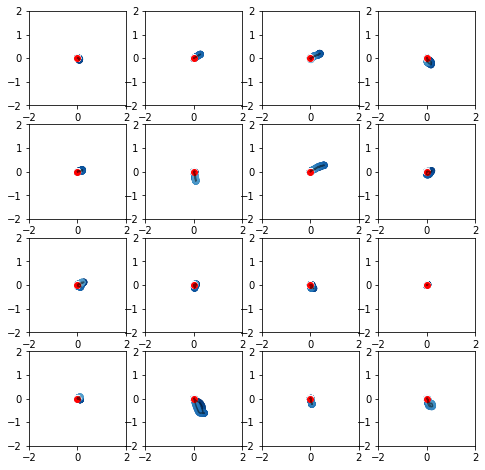

 19% (998 of 5000) |####                 | Elapsed Time: 0:00:42 ETA:   0:02:40


Epoch [1001/5000] -----------------------------------------------------------------------------
G: 0.5, Dr : 0.0, Df : 0.01


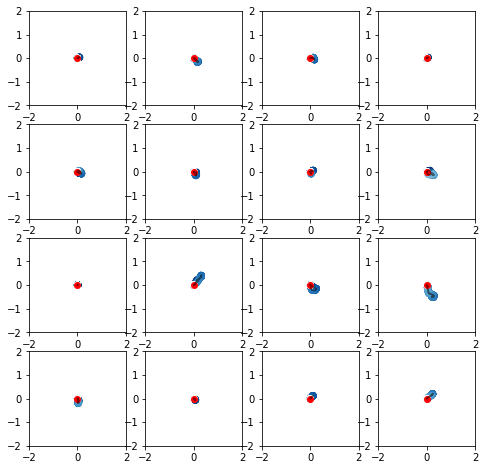

 29% (1498 of 5000) |#####               | Elapsed Time: 0:01:04 ETA:   0:02:15


Epoch [1501/5000] -----------------------------------------------------------------------------
G: 0.36, Dr : 0.03, Df : 0.0


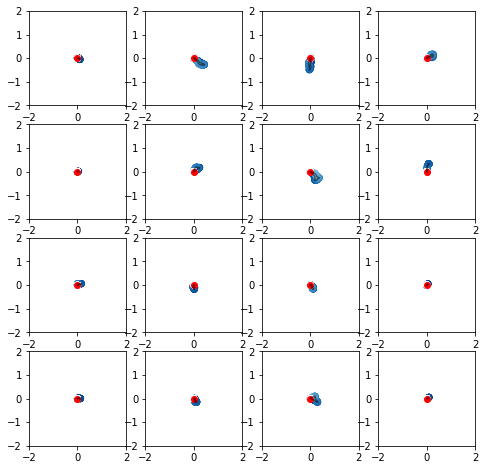

 39% (1998 of 5000) |#######             | Elapsed Time: 0:01:26 ETA:   0:01:57


Epoch [2001/5000] -----------------------------------------------------------------------------
G: 0.42, Dr : 0.0, Df : 0.0


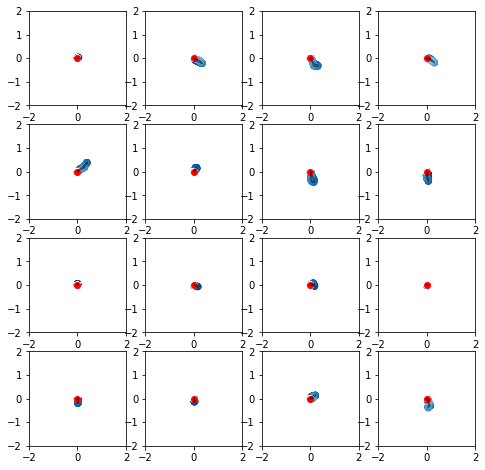

 49% (2497 of 5000) |#########           | Elapsed Time: 0:01:48 ETA:   0:01:40


Epoch [2501/5000] -----------------------------------------------------------------------------
G: 0.55, Dr : 0.0, Df : 0.0


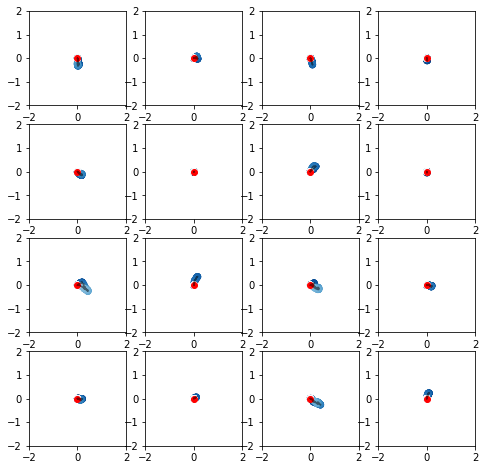

 59% (2999 of 5000) |###########         | Elapsed Time: 0:02:11 ETA:   0:01:20


Epoch [3001/5000] -----------------------------------------------------------------------------
G: 0.72, Dr : 0.0, Df : 0.0


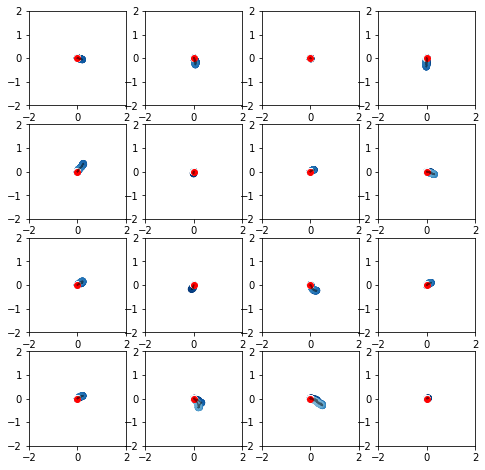

 69% (3499 of 5000) |#############       | Elapsed Time: 0:02:33 ETA:   0:00:59


Epoch [3501/5000] -----------------------------------------------------------------------------
G: 0.45, Dr : 0.0, Df : 0.0


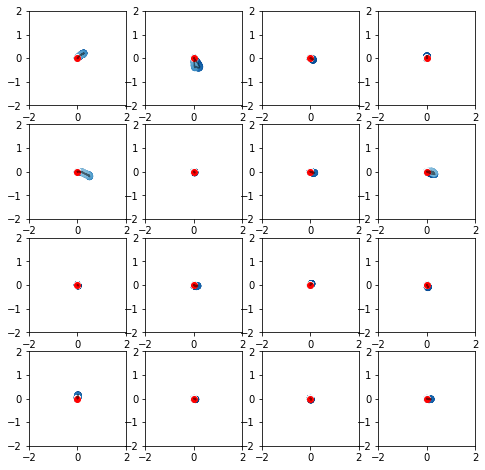

 79% (3999 of 5000) |###############     | Elapsed Time: 0:02:55 ETA:   0:00:39


Epoch [4001/5000] -----------------------------------------------------------------------------
G: 0.52, Dr : 0.0, Df : 0.05


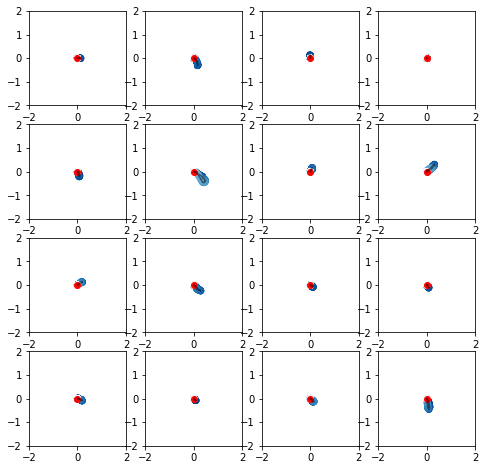

 89% (4499 of 5000) |#################   | Elapsed Time: 0:03:18 ETA:   0:00:20


Epoch [4501/5000] -----------------------------------------------------------------------------
G: 0.73, Dr : 0.0, Df : 0.0


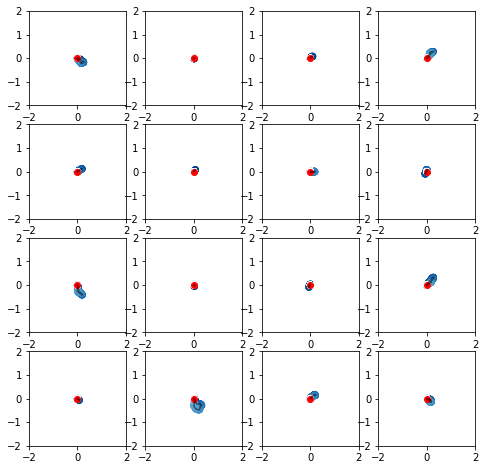

 99% (4997 of 5000) |################### | Elapsed Time: 0:03:40 ETA:   0:00:00


Epoch [5001/5000] -----------------------------------------------------------------------------
G: 0.69, Dr : 0.0, Df : 0.0


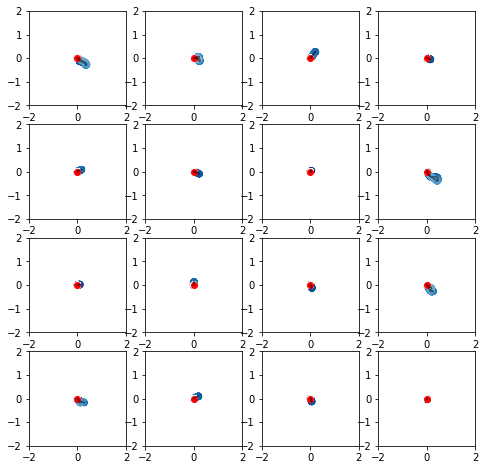

100% (5000 of 5000) |####################| Elapsed Time: 0:03:42 Time:  0:03:42


In [27]:
# Train the model
nb_epoch = 5000
score = []

time_start = time.perf_counter()
epoch = 0
for i in progressbar.progressbar(range(nb_epoch)):
    epoch +=1
    loss_g_running, loss_d_real_running, loss_d_fake_running = 0, 0, 0
    for batch, x in enumerate(train_loader):
        
        #### TRAIN DISCRIMINATOR
        ## true samples
        x = x.to(device)
        batch_size = x.shape[0]

        target_ones = torch.ones((batch_size, 1), device=device)
        target_zeros = torch.zeros((batch_size, 1), device=device)

        discriminator.zero_grad()
        pred_real = discriminator(x)
        loss_real = criterion(pred_real, target_ones)

        ## false samples
        z = torch.randn((batch_size, 256, 1), device=device)
        with torch.no_grad():
            fake_samples = generator(z)
        pred_fake = discriminator(fake_samples)
        loss_fake = criterion(pred_fake, target_zeros)
        
        # combine
        loss = (loss_real + loss_fake) / 2
        loss.backward()
        optim_d.step()

        loss_d_real_running += loss_real.item()
        loss_d_fake_running += loss_fake.item()

        #### TRAIN GENERATOR
        generator.zero_grad()
        z = torch.randn((batch_size, 256, 1), device=device)

        generated = generator(z)
        classifications = discriminator(generated)
        loss = criterion(classifications, target_ones) +  10*torch.mean((periodogram(generated) - periodogram(x))**2)
        loss.backward()
        optim_g.step()

        loss_g_running += loss.item()   

        score.append(torch.mean((periodogram(generated) - periodogram(x))**2))

    if epoch%500 == 0:
        print('\nEpoch [{}/{}] -----------------------------------------------------------------------------'
            .format(epoch+1, nb_epoch, i, len(train_loader)))
        print('G: {}, Dr : {}, Df : {}'
            .format(np.round(loss_g_running/batch_size, 2), np.round(loss_d_real_running/batch_size, 2), np.round(loss_d_fake_running/batch_size, 2)))
        
        nb = 16
        z = torch.randn((nb, 256, 1), device=device)
        with torch.no_grad():
          generated = generator(z)
        
        traj_sim = generated.cpu().detach().numpy()

        plt.figure(figsize = (8,8))

        for i in range(16):
          plt.subplot(4,4,i+1)
          plt.plot(traj_sim[i,0,:], traj_sim[i,1,:], c = 'black', alpha = 0.5)
          plt.scatter(traj_sim[i,0,:], traj_sim[i,1,:], c=np.arange(padding), cmap='Blues_r')
          plt.scatter(0,0, c = 'red')
          plt.xlim(-2,2)
          plt.ylim(-2,2)

        plt.show()
        plt.close()

In [28]:
with open('./results/score_SD_2.npy', 'wb') as f:
    np.save(f, score)

torch.save(generator, './results/G_SD_2.pt')
torch.save(discriminator, './results/D_SD_2.pt')

# Results

In [29]:
score_1 = np.load('./results/score_SD_1.npy', allow_pickle=True)
score_2 = np.load('./results/score_SD_2.npy', allow_pickle=True)
# score_3 = np.load('score_SD_3.npy', allow_pickle=True)

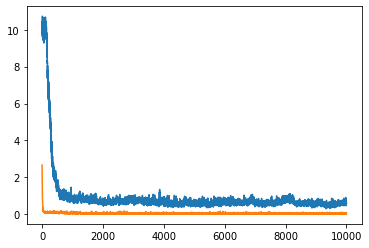

In [30]:
plt.plot(score_1)
plt.plot(score_2)
# plt.plot(score_3)

In [31]:
colony =  (-32.392, -3.819)
scale = 2e5

generator = torch.load('./results/G_SD_1.pt')
nb = 100
z = torch.randn((100, 256, 1), device=device)
with torch.no_grad():
  generated = generator(z)
traj_sim_1 = generated.cpu().detach().numpy()
(x_1, lon_1, lat_1) = get_periodogram(traj_sim_1)
data_fake_1 = format_simulation(traj_sim_1, colony, scale)
data_fake_1 = data_fake_1[data_fake_1.dist_colony > 1000]

generator = torch.load('./results/G_SD_2.pt')
nb = 100
z = torch.randn((100, 256, 1), device=device)
with torch.no_grad():
  generated = generator(z)
traj_sim_2 = generated.cpu().detach().numpy()
(x_2, lon_2, lat_2) = get_periodogram(traj_sim_2)
data_fake_2 = format_simulation(traj_sim_2, colony, scale)
data_fake_2 = data_fake_2[data_fake_2.dist_colony > 1000]

# generator = torch.load('./results/G_SD_3.pt')
# nb = 100
# z = torch.randn((100, 256, 1), device=device)
# with torch.no_grad():
#   generated = generator(z)
# traj_sim_3 = generated.cpu().detach().numpy()
# (x_3, lon_3, lat_3) = get_periodogram(traj_sim_3)
# data_fake_3 = format_simulation(traj_sim_3, colony, scale)
# data_fake_3 = data_fake_3[data_fake_3.dist_colony > 1000]

(x_real, lon_real, lat_real) = get_periodogram(traj)

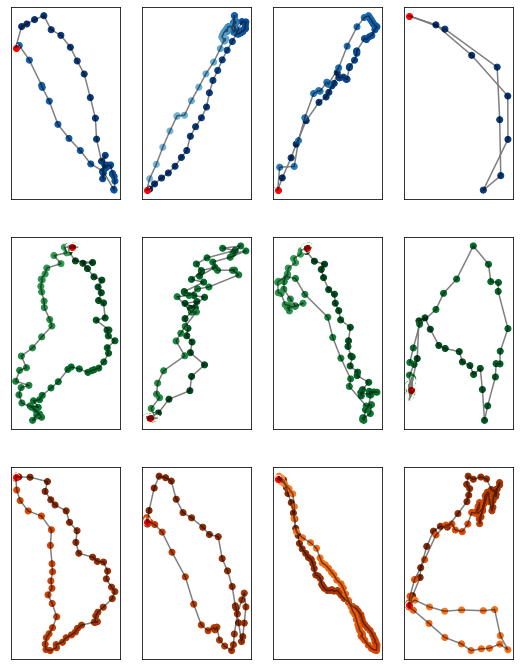

In [32]:
nb = [1, 2, 3, 4]
k=1
plt.figure(figsize=(9,12))


for i in nb:
    plt.subplot(3,4,k)
    plt.plot(traj[i,0,:], traj[i,1,:], c = 'black', alpha = 0.5)
    plt.scatter(traj[i,0,:], traj[i,1,:], c=np.arange(traj.shape[2]), cmap='Blues_r')
    plt.scatter(0,0, c = 'red')
#     plt.xlim(-1,1)
#     plt.ylim(-1,1)
#     plt.yticks([-1, 0, 1], ["-1", "0", "1"])
    plt.ylabel('Real Data')
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    k+=1


for i in nb:
    plt.subplot(3,4,k)
    plt.plot(traj_sim_1[i,0,:], traj_sim_1[i,1,:], c = 'black', alpha = 0.5)
    plt.scatter(traj_sim_1[i,0,:], traj_sim_1[i,1,:], c=np.arange(traj_sim_1.shape[2]), cmap='Greens_r')
    plt.scatter(0,0, c = 'red')
#     plt.xlim(-1,1)
#     plt.ylim(-1,1)
#     plt.yticks([-1, 0, 1], ["-1", "0", "1"])
    plt.ylabel('GAN')
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    k+=1


for i in nb:
    plt.subplot(3,4,k)
    plt.plot(traj_sim_2[i,0,:], traj_sim_2[i,1,:], c = 'black', alpha = 0.5)
    plt.scatter(traj_sim_2[i,0,:], traj_sim_2[i,1,:], c=np.arange(traj_sim_2.shape[2]), cmap='Oranges_r')
    plt.scatter(0,0, c = 'red')
#     plt.xlim(-1,1)
#     plt.ylim(-1,1)
#     plt.yticks([-1, 0, 1], ["-1", "0", "1"])
    plt.ylabel('GAN + Fourier')
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    k+=1


# for i in nb:
#     plt.subplot(4,4,k)
#     plt.plot(traj_sim_3[i,0,:], traj_sim_3[i,1,:], c = 'black', alpha = 0.5)
#     plt.scatter(traj_sim_3[i,0,:], traj_sim_3[i,1,:], c=np.arange(traj_sim_3.shape[2]), cmap='Greens_r')
#     plt.scatter(0,0, c = 'red')
# #     plt.xlim(-1,1)
# #     plt.ylim(-1,1)
# #     plt.yticks([-1, 0, 1], ["-1", "0", "1"])
#     plt.ylabel('GAN + Fourier + step')
#     ax = plt.gca()
#     ax.axes.xaxis.set_visible(False)
#     ax.axes.yaxis.set_visible(False)
#     k+=1

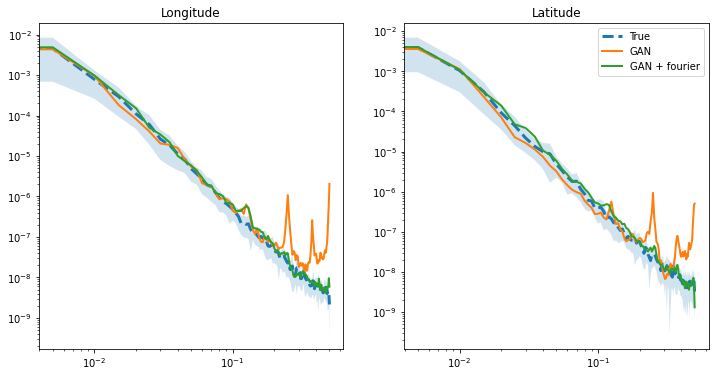

In [33]:
plt.figure(figsize = (12,6))

plt.subplot(1,2,1)
plt.loglog(x_real, np.mean(lon_real, axis=0), linewidth = 3, linestyle = '--')
plt.fill_between(x_real, np.mean(lon_real, axis=0) - 0.5 * np.std(lon_real, axis=0) ,
                np.mean(lon_real, axis=0) + 0.5 * np.std(lon_real, axis=0),
                alpha = 0.2)


plt.loglog(x_real, np.mean(lon_1, axis=0), linewidth = 2)
plt.loglog(x_real, np.mean(lon_2, axis=0), linewidth = 2)
# plt.loglog(x_real, np.mean(lon_3, axis=0), linewidth = 2)

plt.title('Longitude')

plt.subplot(1,2,2)
plt.loglog(x_real, np.mean(lat_real, axis=0), linewidth = 3, linestyle = '--', label = 'True')
plt.fill_between(x_real, np.mean(lat_real, axis=0) - 0.5 * np.std(lat_real, axis=0) ,
                np.mean(lat_real, axis=0) + 0.5 * np.std(lat_real, axis=0),
                alpha = 0.2)

plt.loglog(x_real, np.mean(lat_1, axis=0), linewidth = 2, label = 'GAN')
plt.loglog(x_real, np.mean(lat_2, axis=0), linewidth = 2, label = 'GAN + fourier')
# plt.loglog(x_real, np.mean(lat_3, axis=0), linewidth = 2, label = 'GAN + fourier + step')


# plt.xlim([0, 0.5])
# plt.ylim([1e-6, 1e1])
plt.legend()
plt.title('Latitude')

plt.show()

Text(0.5, 1.0, 'Step Direction (degree)')

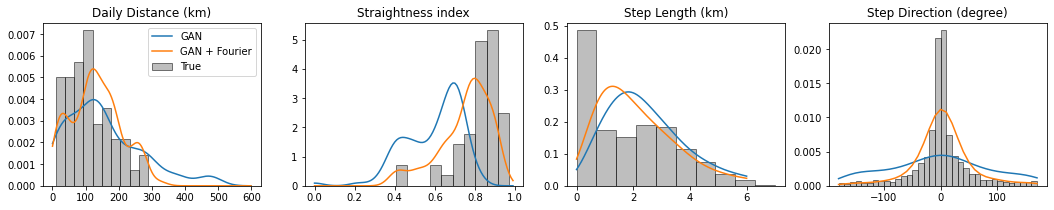

In [37]:
plt.figure(figsize = (18,3))

plt.subplot(1,4,1)
## DAILY DISTANCE
y = get_trip_dist(data)
y_1 = get_trip_dist(data_fake_1)
y_2 = get_trip_dist(data_fake_2)
# y_3 = get_trip_dist(data_fake_3)
dy_1 = kde1d(y_1/1e3, bw = 0.3)
dy_2 = kde1d(y_2/1e3, bw = 0.3)
# dy_3 = kde1d(y_3/1e3, bw = 0.3)

x = np.arange(0,600, 1)
plt.hist(y/1e3, color = dicolour['gray'], label = 'True', alpha = 0.5, edgecolor='k', density = True)
plt.plot(x, dy_1(x), color = dicolour['blue'], label = 'GAN')
plt.plot(x, dy_2(x), color = dicolour['orange'], label = 'GAN + Fourier')
# plt.plot(x, dy_3(x), color = dicolour['green'], label = 'GAN + Fourier+ step')
plt.legend()
plt.title('Daily Distance (km)')

plt.subplot(1,4,2)
# STRAIGHTNESS INDEX
y = get_trip_sinuosity(data)
y_1 = get_trip_sinuosity(data_fake_1)
y_2 = get_trip_sinuosity(data_fake_2)
# y_3 = get_trip_sinuosity(data_fake_3)
dy_1 = kde1d(y_1, bw = 0.3)
dy_2 = kde1d(y_2, bw = 0.3)
# dy_3 = kde1d(y_3, bw = 0.3)


x = np.arange(0,1, 0.01)
plt.hist(y, color = dicolour['gray'], label = 'True', alpha = 0.5, edgecolor='k', density = True)
plt.plot(x, dy_1(x), color = dicolour['blue'], label = 'GAN')
plt.plot(x, dy_2(x), color = dicolour['orange'], label = 'GAN + Fourier')
# plt.plot(x, dy_3(x), color = dicolour['green'], label = 'GAN + Fourier+ step')
plt.title('Straightness index')

plt.subplot(1,4,3)
# STEP LENGTH
y_1 = data_fake_1.step_distance/1e3
y_2 = data_fake_2.step_distance/1e3
# y_3 = data_fake_3.step_distance/1e3
dy_1 = kde1d(y_1.dropna(), bw = 0.3)
dy_2 = kde1d(y_2.dropna(), bw = 0.3)
# dy_3 = kde1d(y_3.dropna(), bw = 0.3)

x = np.arange(0,6, 0.01)
plt.hist(data.step_distance.dropna()/1e3, color = dicolour['gray'], label = 'True', alpha = 0.5, edgecolor='k', density = True)
plt.plot(x, dy_1(x), color = dicolour['blue'], label = 'GAN')
plt.plot(x, dy_2(x), color = dicolour['orange'], label = 'GAN + Fourier')
# plt.plot(x, dy_3(x), color = dicolour['green'], label = 'GAN + Fourier+ step')
plt.title('Step Length (km)')

plt.subplot(1,4,4)
# STEP DIRECTION
y_1 = data_fake_1.step_direction
y_2 = data_fake_2.step_direction
# y_3 = data_fake_3.step_direction
dy_1 = kde1d(y_1.dropna(), bw = 0.3)
dy_2 = kde1d(y_2.dropna(), bw = 0.3)
# dy_3 = kde1d(y_3.dropna(), bw = 0.3)

x = np.arange(-180,180, 10)
plt.hist(data.step_direction, bins = x, color = dicolour['gray'], label = 'True', alpha = 0.5, edgecolor='k', density = True)
plt.plot(x, dy_1(x), color = dicolour['blue'], label = 'GAN')
plt.plot(x, dy_2(x), color = dicolour['orange'], label = 'GAN + Fourier')
# plt.plot(x, dy_3(x), color = dicolour['green'], label = 'GAN + Fourier+ step')
plt.title('Step Direction (degree)')


In [35]:
def scaled_steps(data, scale):

  scaled_st = []

  for t in data.trip:
    steps = data.step_distance[data.trip == t].values
    for i in range(0,len(steps)-scale,scale):
      scaled_st.append(np.mean(steps[i:i+scale]))
      
  return np.array(scaled_st)

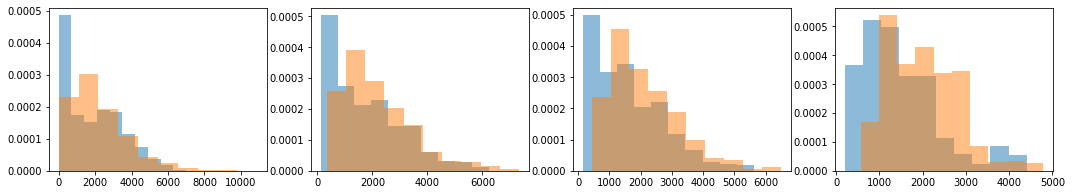

In [36]:
plt.figure(figsize = (18,3))

plt.subplot(1,4,1)
plt.hist(data.step_distance, alpha = 0.5, density = True)
plt.hist(data_fake_2.step_distance, alpha = 0.5, density = True)

plt.subplot(1,4,2)
scale = 5
plt.hist(scaled_steps(data, scale), alpha = 0.5, density = True)
plt.hist(scaled_steps(data_fake_2, scale), alpha = 0.5, density = True)

plt.subplot(1,4,3)
scale = 10
plt.hist(scaled_steps(data, scale), alpha = 0.5, density = True)
plt.hist(scaled_steps(data_fake_2, scale), alpha = 0.5, density = True)

plt.subplot(1,4,4)
scale = 20
plt.hist(scaled_steps(data, scale), alpha = 0.5, density = True)
plt.hist(scaled_steps(data_fake_2, scale), alpha = 0.5, density = True)

plt.show()